In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define a simple single-neuron model
class SingleNeuronModel(nn.Module):
    def __init__(self):
        super(SingleNeuronModel, self).__init__()
        self.output = nn.Linear(28 * 28, 1)  # Only 1 neuron, no hidden layers

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten image
        return torch.sigmoid(self.output(x))  # Output between 0 and 1

# Load dataset (no normalization, just convert to tensors)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize model, loss, and optimizer
model = SingleNeuronModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train model
for epoch in range(3):  # Few epochs just for testing
    total_loss = 0
    for images, labels in train_loader:
        labels = labels.float() / 10  # Normalize labels to range [0, 1]

        optimizer.zero_grad()
        outputs = model(images).squeeze()  # Get model output
        loss = criterion(outputs, labels)  # Compute MSE loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

# Evaluate accuracy
def evaluate_accuracy(data_loader, dataset_name):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images).squeeze()
            # Multiply by 9, round, and clip to ensure the output is in the range [0, 9]
            predictions = torch.round(outputs * 9).clamp(0, 9)  # Convert back to digit range [0, 9]
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    print(f"{dataset_name} Accuracy: {accuracy:.2f}%")
    return accuracy

train_accuracy = evaluate_accuracy(train_loader, "Train")
test_accuracy = evaluate_accuracy(test_loader, "Test")

# Collect outputs for histogram plots
def collect_outputs(data_loader):
    outputs, labels_list = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            labels_list.extend(labels.tolist())
            # Multiply by 9, round, and clip to ensure the output is in the range [0, 9]
            rounded_outputs = torch.round(model(images).squeeze() * 9).clamp(0, 9)  # Convert to digit range [0, 9]
            outputs.extend(rounded_outputs.tolist())
    return outputs, labels_list

train_outputs, train_labels_list = collect_outputs(train_loader)
test_outputs, test_labels_list = collect_outputs(test_loader)


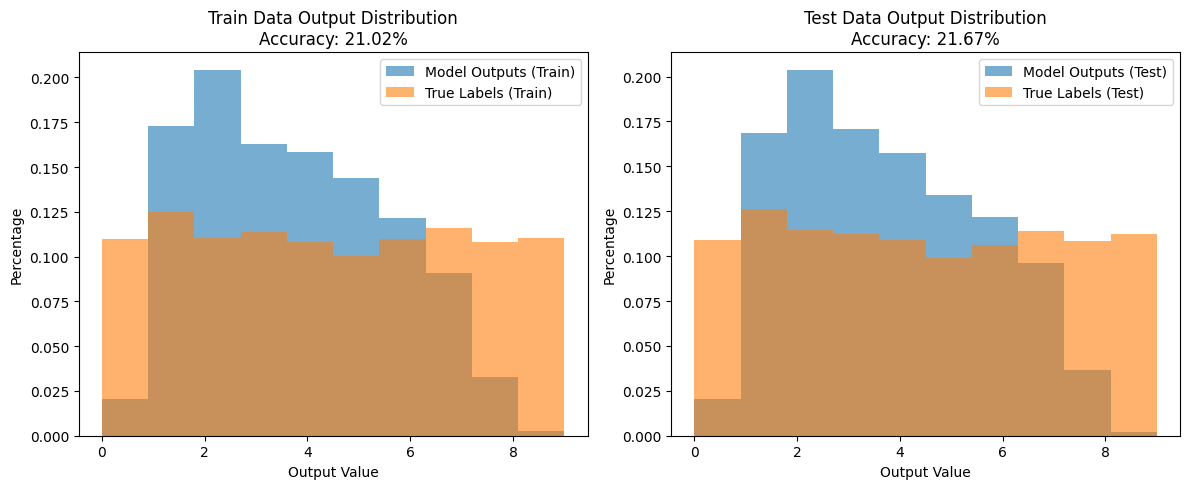

In [20]:
# Plot histograms with percentages
plt.figure(figsize=(12, 5))

# Train data histogram
plt.subplot(1, 2, 1)
plt.hist(train_outputs, bins=10, alpha=0.6, label="Model Outputs (Train)", density=True)
plt.hist([l for l in train_labels_list], bins=10, alpha=0.6, label="True Labels (Train)", density=True)
plt.legend()
plt.title(f"Train Data Output Distribution\nAccuracy: {train_accuracy:.2f}%")
plt.xlabel("Output Value")
plt.ylabel("Percentage")

# Test data histogram
plt.subplot(1, 2, 2)
plt.hist(test_outputs, bins=10, alpha=0.6, label="Model Outputs (Test)", density=True)
plt.hist([l for l in test_labels_list], bins=10, alpha=0.6, label="True Labels (Test)", density=True)
plt.legend()
plt.title(f"Test Data Output Distribution\nAccuracy: {test_accuracy:.2f}%")
plt.xlabel("Output Value")
plt.ylabel("Percentage")

plt.tight_layout()
plt.show()

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define a single output neuron
class SingleNeuronModel(nn.Module):
    def __init__(self):
        super(SingleNeuronModel, self).__init__()
        self.output = nn.Parameter(torch.randn(1, requires_grad=True))  # Single learnable neuron

    def forward(self):
        prob = torch.sigmoid(self.output)  # Convert to probability (0 to 1)
        sampled_digit = torch.randint(0, 10, (1,)).float()  # Sample random digit
        return prob * 9 + (1 - prob) * sampled_digit  # Mix learned value with randomness

# Load dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Compute the empirical digit distribution in the training set
digit_counts = torch.zeros(10)
for _, labels in train_loader:
    for label in labels:
        digit_counts[label] += 1

digit_probs = digit_counts / digit_counts.sum()  # Normalize to probability distribution
expected_value = (torch.arange(10) * digit_probs).sum() / 9  # Normalize to [0,1]

# Initialize model, loss, and optimizer
model = SingleNeuronModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train model
for epoch in range(1000):  # More epochs since there's only one parameter to learn
    optimizer.zero_grad()
    output = model()
    loss = criterion(output / 9, expected_value)  # Train neuron to predict digit distribution mean
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}, Output: {output.item():.4f}")

# Print final learned value
final_output = model().item()  # Direct sampled value
print(f"Final predicted digit (randomized): {final_output:.4f}")

# Function to evaluate accuracy
def evaluate_accuracy(data_loader, dataset_name, num_samples=10):
    correct = 0
    total = 0
    with torch.no_grad():
        for _, labels in data_loader:
            batch_size = labels.size(0)
            predictions = torch.zeros(batch_size, num_samples)

            # Generate multiple predictions per sample
            for i in range(num_samples):
                predictions[:, i] = model()

            # Pick the most frequent prediction for each sample
            final_predictions, _ = predictions.mode(dim=1)

            correct += (final_predictions == labels).sum().item()
            total += batch_size

    accuracy = 100 * correct / total
    print(f"{dataset_name} Accuracy: {accuracy:.2f}%")
    return accuracy

# Compute accuracy
train_accuracy = evaluate_accuracy(train_loader, "Train")
test_accuracy = evaluate_accuracy(test_loader, "Test")


Epoch 0, Loss: 0.233600, Output: 8.8038
Epoch 100, Loss: 0.065384, Output: 6.7553
Epoch 200, Loss: 0.146708, Output: 7.9012
Epoch 300, Loss: 0.084630, Output: 7.0721
Epoch 400, Loss: 0.074212, Output: 6.9057
Epoch 500, Loss: 0.183660, Output: 8.3109
Epoch 600, Loss: 0.180109, Output: 8.2735
Epoch 700, Loss: 0.182669, Output: 8.3005
Epoch 800, Loss: 0.255145, Output: 9.0000
Epoch 900, Loss: 0.069205, Output: 6.8216
Final predicted digit (randomized): 6.1478
Train Accuracy: 0.60%
Test Accuracy: 0.42%


In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Load dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to compute digit distribution
def compute_digit_distribution(data_loader):
    digit_counts = torch.zeros(10)
    total_samples = 0
    
    for _, labels in data_loader:
        for label in labels:
            digit_counts[label] += 1
        total_samples += labels.size(0)

    digit_percentages = (digit_counts / total_samples) * 100  # Convert to percentage
    return digit_counts.int().tolist(), digit_percentages.tolist()

# Compute distributions
train_counts, train_percentages = compute_digit_distribution(train_loader)
test_counts, test_percentages = compute_digit_distribution(test_loader)

# Print results
print("Train Set Digit Distribution:")
for digit, (count, percent) in enumerate(zip(train_counts, train_percentages)):
    print(f"Digit {digit}: {count} ({percent:.2f}%)")

print("\nTest Set Digit Distribution:")
for digit, (count, percent) in enumerate(zip(test_counts, test_percentages)):
    print(f"Digit {digit}: {count} ({percent:.2f}%)")


Train Set Digit Distribution:
Digit 0: 5923 (9.87%)
Digit 1: 6742 (11.24%)
Digit 2: 5958 (9.93%)
Digit 3: 6131 (10.22%)
Digit 4: 5842 (9.74%)
Digit 5: 5421 (9.03%)
Digit 6: 5918 (9.86%)
Digit 7: 6265 (10.44%)
Digit 8: 5851 (9.75%)
Digit 9: 5949 (9.91%)

Test Set Digit Distribution:
Digit 0: 980 (9.80%)
Digit 1: 1135 (11.35%)
Digit 2: 1032 (10.32%)
Digit 3: 1010 (10.10%)
Digit 4: 982 (9.82%)
Digit 5: 892 (8.92%)
Digit 6: 958 (9.58%)
Digit 7: 1028 (10.28%)
Digit 8: 974 (9.74%)
Digit 9: 1009 (10.09%)


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define a single output neuron that learns the digit distribution
class SingleNeuronModel(nn.Module):
    def __init__(self):
        super(SingleNeuronModel, self).__init__()
        self.output = nn.Parameter(torch.randn(1, requires_grad=True))  # Single learnable neuron

    def forward(self):
        return torch.sigmoid(self.output) * 9  # Scale output to [0, 9]

# Load dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Compute the empirical digit distribution in the training set
digit_counts = torch.zeros(10)
for _, labels in train_loader:
    for label in labels:
        digit_counts[label] += 1

digit_probs = digit_counts / digit_counts.sum()  # Normalize to probability distribution
expected_value = (torch.arange(10) * digit_probs).sum()  # Compute expected digit mean

# Initialize model, loss, and optimizer
model = SingleNeuronModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train model
for epoch in range(1000):
    optimizer.zero_grad()
    output = model()  # Model now outputs a differentiable value
    loss = criterion(output, expected_value)  # Train neuron to match the dataset mean
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}, Output: {output.item():.4f}")

# Print final learned value
final_output = model().item()
print(f"Final predicted digit: {final_output:.4f}")

# Function to evaluate accuracy
def evaluate_accuracy(data_loader, dataset_name):
    correct = 0
    total = 0
    with torch.no_grad():
        for _, labels in data_loader:
            batch_size = labels.size(0)
            predictions = torch.round(model()).repeat(batch_size)  # Repeat same prediction for batch
            correct += (predictions == labels).sum().item()
            total += batch_size

    accuracy = 100 * correct / total
    print(f"{dataset_name} Accuracy: {accuracy:.2f}%")
    return accuracy

# Compute accuracy
train_accuracy = evaluate_accuracy(train_loader, "Train")
test_accuracy = evaluate_accuracy(test_loader, "Test")


Epoch 0, Loss: 1.002951, Output: 5.4554
Epoch 100, Loss: 0.000107, Output: 4.4436
Epoch 200, Loss: 0.000000, Output: 4.4539
Epoch 300, Loss: 0.000000, Output: 4.4539
Epoch 400, Loss: 0.000000, Output: 4.4539
Epoch 500, Loss: 0.000000, Output: 4.4539
Epoch 600, Loss: 0.000000, Output: 4.4539
Epoch 700, Loss: 0.000000, Output: 4.4539
Epoch 800, Loss: 0.000000, Output: 4.4539
Epoch 900, Loss: 0.000000, Output: 4.4539
Final predicted digit: 4.4539
Train Accuracy: 9.74%
Test Accuracy: 9.82%
